### 数据处理

In [42]:
import numpy as np
import re
import matplotlib.pyplot as plt

**读取数据**

In [2]:
user_data = sc.textFile("/test/ml-100k/u.user")
movie_data = sc.textFile("/test/ml-100k/u.item")
ratings_data = sc.textFile("/test/ml-100k/u.data")

In [3]:
print(user_data.first())
print(movie_data.first())
print(ratings_data.first())

1|24|M|technician|85711
1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
196	242	3	881250949


**对RDD的数据进行处理(切分)**

In [4]:
user_rdd = user_data.map(lambda line: line.split("|"))
movie_rdd = movie_data.map(lambda line: line.split("|"))
ratings_rdd = ratings_data.map(lambda line: line.split("\t"))


In [5]:
# 将RDD转化为DF
user_df = sqlContext.createDataFrame(user_rdd).toPandas()
movie_df = sqlContext.createDataFrame(movie_rdd).toPandas()
ratings_df = sqlContext.createDataFrame(ratings_rdd).toPandas()


In [6]:
# Rename列名
user_df.columns = ['UserID',"Age",'Gender',"Occupation","Zip-code"]
ratings_df.columns = ['UserID','MovieID',"Rating","Timestamp"]
# movie_df.columns = ['MovieID','Title',"ReleaseDate","VideoLink","Other"]

### 探索用户数据

In [7]:
# 获取评分RDD
ratings = user_rdd.map(lambda fields: int(fields[2]))

In [8]:
ratings_df[:5]

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:

# 统计用户数
num_users = user_rdd.map(lambda fields: fields[0]).count()
# 统计性别数
num_genders = user_rdd.map(lambda fields: fields[2]).distinct().count()
# 统计职业数
num_occupations = user_rdd.map(lambda fields: fields[3]).distinct().count()
# 统计邮编数
num_zipcodes = user_rdd.map(lambda fields: fields[4]).distinct().count()
# 返回结果

In [10]:
print( "用户数: %d, 性别数: %d, 职业数: %d, 邮编数: %d" % (num_users, num_genders, num_occupations, num_zipcodes))

用户数: 943, 性别数: 2, 职业数: 21, 邮编数: 795


In [12]:
# 获取用户年龄RDD，并将其落地到驱动程序
ages = user_rdd.map(lambda x: int(x[1])).collect()

/home/heitao/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


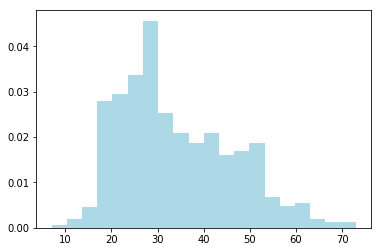

In [13]:
# 绘制用户年龄直方图

age_hist= plt.hist(ages, bins=20, color='lightblue', normed=True)

In [14]:
# 并行统计各职业人数的个数，返回职业统计RDD后落地
count_by_occupation = user_rdd.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
# count_by_occupation2 = user_rdd.map(lambda fields: fields[3]).countByValue()

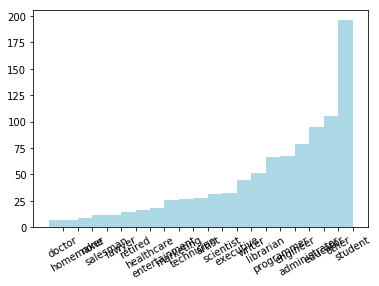

In [15]:
# 生成x/y坐标轴
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]
 
# 生成x轴标签
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)
 
# 绘制职业人数条状图
plt.xticks(rotation=30)
occupation_bar = plt.bar(pos, y_axis, width, color='lightblue')

In [16]:
count_by_occupation2 = user_rdd.map(lambda fields: fields[3]).countByValue()

In [19]:
# 统计各职业人数

In [18]:
count_by_occupation2

defaultdict(int,
            {'technician': 27,
             'other': 105,
             'writer': 45,
             'executive': 32,
             'administrator': 79,
             'student': 196,
             'lawyer': 12,
             'educator': 95,
             'scientist': 31,
             'entertainment': 18,
             'programmer': 66,
             'librarian': 51,
             'homemaker': 7,
             'artist': 28,
             'engineer': 67,
             'marketing': 26,
             'none': 9,
             'healthcare': 16,
             'retired': 14,
             'salesman': 12,
             'doctor': 7})

### 探索电影数据

In [24]:

num_movies = movie_rdd.count()

num_movies

1682

In [35]:
# 输入影片的发行时间字段，若非法则返回1900
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900
 
# 以' | '切分每列，返回影片RDD
movie_fields = movie_data.map(lambda lines: lines.split("|"))
# 生成新的影片发行年份RDD，并将空/异常的年份置为1900，
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
# 过滤掉影片发行年份RDD中空/异常的记录
years_filtered = years.filter(lambda x: x != 1900)

In [38]:
# 生成影片年龄RDD，然后统计不同年龄的影片数并落地
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
# 获得影片数
values = movie_ages.values()
# 获得年龄
bins = movie_ages.keys()

In [105]:
bins

dict_keys([3, 2, 4, 31, 21, 5, 33, 16, 8, 6, 7, 61, 1, 17, 28, 26, 37, 59, 57, 30, 29, 44, 27, 10, 25, 19, 11, 12, 9, 24, 18, 13, 32, 41, 38, 14, 15, 23, 0, 58, 48, 34, 47, 36, 65, 42, 35, 40, 53, 22, 20, 39, 56, 45, 52, 43, 60, 64, 49, 50, 55, 54, 62, 63, 68, 46, 67, 76, 51, 66, 72])

In [ ]:
# 生成影片年龄RDD，然后统计不同年龄的影片数并落地
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
# 获得影片数
values = movie_ages.values()
# 获得年龄
bins = movie_ages.keys()
# 绘制电影年龄分布图
# plt.hist(values, bins=bins, color='lightblue', normed=True)

### 探索评级数据

In [70]:
num_ratings = ratings_rdd.count()

In [71]:
num_ratings

100000

In [72]:
# 获取评分RDD
ratings  = ratings_rdd.map(lambda fields: int(fields[2]))

In [73]:
# 计算最大/最小评分
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))

In [74]:
# 计算平均/中位评分
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())

In [75]:
# 计算每个观众/每部电影平均打分/被打分次数
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies

In [76]:
print("最低评分: %d" % min_rating)
print("最高评分: %d" % max_rating)
print("平均评分: %2.2f" % mean_rating)
print("中位评分: %d" % median_rating)
print("平均每个用户打分(次数): %2.2f" % ratings_per_user)
print("平均每部电影评分(次数): %2.2f" % ratings_per_movie)

最低评分: 1
最高评分: 5
平均评分: 3.53
中位评分: 4
平均每个用户打分(次数): 106.04
平均每部电影评分(次数): 59.45


In [77]:
ratings.stats()

(count: 100000, mean: 3.5298600000000024, stdev: 1.125667970762251, max: 5.0, min: 1.0)

In [78]:
# 生成评分统计RDD，并落地
count_by_rating = ratings.countByValue()

In [79]:
# 生成x/y坐标轴
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])

In [80]:
# 对人数做标准化
y_axis_normed = y_axis / y_axis.sum()

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

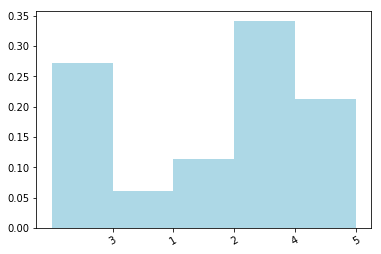

In [81]:
# 生成评分统计RDD，并落地
count_by_rating = ratings.countByValue()
# 生成x/y坐标轴
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
# 对人数做标准化
y_axis_normed = y_axis / y_axis.sum()
 
# 生成x轴标签
pos = np.arange(len(x_axis.sum()))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis.sum())
 
# 绘制评分分布柱状图
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)

In [82]:
# 首先将数据以用户id为Key分发到各个节点
user_ratings_grouped = ratings_rdd.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey() 


In [88]:
# 输出前5条记录.take(5)
user_ratings_grouped.take(5)

[(196, <pyspark.resultiterable.ResultIterable at 0x7f492138f940>),
 (186, <pyspark.resultiterable.ResultIterable at 0x7f492138fa20>),
 (22, <pyspark.resultiterable.ResultIterable at 0x7f492138fac8>),
 (244, <pyspark.resultiterable.ResultIterable at 0x7f492138f9b0>),
 (166, <pyspark.resultiterable.ResultIterable at 0x7f492138fb38>)]

In [84]:
ratings_df[:3]

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [85]:
# 函数: 将时间戳格式转换为datetime格式
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)

In [86]:
# 获取小时RDD
timestamps = ratings_rdd.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)

In [87]:
hour_of_day.take(3)

[23, 3, 15]

## 使用Spark对MovieLens的特征进行提取

In [90]:
# 获取职业RDD并落地
all_occupations = user_rdd.map(lambda fields: fields[3]).distinct().collect()
# 对各职业进行排序
all_occupations.sort()
 

In [92]:
# 构建字典
idx = 0
all_occupations_dict = {}
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1
 
# 生成并打印职业为程序员(programmer)的1 of k编码
K = len(all_occupations_dict)
binary_x = np.zeros(K)
k_programmer = all_occupations_dict['programmer']
binary_x[k_programmer] = 1
print("职业编号为“1”的1 of k编码为: %s" % binary_x)

职业编号为“1”的1 of k编码为: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### 派生特征提取

In [46]:
# 获取评分RDD

ratings = ratings_rdd.map(lambda fields: int(fields[2]))
 

In [94]:
# 函数: 将时间戳格式转换为datetime格式
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)

In [95]:
# 获取小时RDD
timestamps = ratings_rdd.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)

In [96]:
# 函数: 将小时映射为分类变量并展示
def assign_tod(hr):

    if hr >7 and hr < 12 :
        return 'morning'
    elif hr >11 and hr < 14 :
        return 'lunch'
    elif hr >13 and hr < 18 :
        return 'afternoon'
    elif hr >17 and hr < 22 :
        return 'evening'
    else:
        return  'night'
    

In [97]:
# 获取新的分类变量RDD
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

['night', 'night', 'afternoon', 'lunch', 'lunch']

### 文本特征提取

In [99]:
# 函数: 剔除掉标题中的(年份)部分
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)", raw)
    if grps:
        return raw[:grps.start()].strip()
    else:
        return raw

In [100]:
# 获取影片名RDD
raw_titles = movie_fields.map(lambda fields: fields[1])
 
# 剔除影片名中的(年份)
movie_titles = raw_titles.map(lambda m: extract_title(m))
 
# 由于仅仅是个展示的例子，简简单单用空格分割
title_terms = movie_titles.map(lambda t: t.split(" "))

In [101]:

# 搜集所有的词
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
# 创建字典
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx +=1
num_terms = len(all_terms_dict)
 
# 函数: 采用稀疏向量格式保存编码后的特征并返回
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x
 
# 将字典保存为广播数据格式类型。因为各个worker都要用
all_terms_bcast = sc.broadcast(all_terms_dict)
# 采用稀疏矩阵格式保存影片名特征
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value))
# 展示提取结果
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

In [102]:
all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()

### 归一化特征

In [103]:
# 设置随机数种子
np.random.seed(42)
# 生成随机向量
x = np.random.randn(10)
# 产生二阶范数
norm_x_2 = np.linalg.norm(x)
# 归一化
normalized_x = x / norm_x_2
 
# 结果展示
print("向量x:\n%s" % x)
print("向量x的2阶范数: %2.4f" % norm_x_2)
print( "归一化后的向量x:\n%s" % normalized_x)
print("归一化后向量x的2阶范数:\n%2.4f" % np.linalg.norm(normalized_x))

向量x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
向量x的2阶范数: 2.5908
归一化后的向量x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
归一化后向量x的2阶范数:
1.0000


In [104]:
# 导入Spark库中的正则化类
from pyspark.mllib.feature import Normalizer
# 初始化正则化对象
normalizer = Normalizer()
# 创建测试向量(RDD)
vector = sc.parallelize([x])
# 对向量进行归一化并返回结果
normalized_x_mllib = normalizer.transform(vector).first().toArray()
  
# 结果展示
print("向量x:\n%s" % x)
print("向量x的二阶范数: %2.4f" % norm_x_2)
print("被MLlib归一化后的向量x:\n%s" % normalized_x_mllib)
print("被MLlib归一化后的向量x的二阶范数: %2.4f" % np.linalg.norm(normalized_x_mllib)) 

向量x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
向量x的二阶范数: 2.5908
被MLlib归一化后的向量x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
被MLlib归一化后的向量x的二阶范数: 1.0000
